In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio

import folium
import folium.plugins
from folium.plugins import MarkerCluster
from ipywidgets import interactive

import datetime
import tensorflow as tf
from tensorflow import keras

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
from copy import deepcopy
%matplotlib inline  

In [10]:
crime = pd.read_csv('/Users/jenniferwu/Documents/BostonCrimeProject/crimes-in-boston/crimetodate_cleaneddata.csv')
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399636 entries, 0 to 399635
Data columns (total 20 columns):
Unnamed: 0             399636 non-null int64
INCIDENT_NUMBER        399636 non-null object
OFFENSE_CODE           399636 non-null int64
OFFENSE_CODE_GROUP     399636 non-null object
OFFENSE_DESCRIPTION    399636 non-null object
DISTRICT               397816 non-null object
REPORTING_AREA         399636 non-null object
SHOOTING               399636 non-null int64
YEAR                   399636 non-null int64
MONTH                  399636 non-null int64
DAY_OF_WEEK            399636 non-null object
HOUR                   399636 non-null int64
UCR_PART               399527 non-null object
STREET                 397111 non-null object
Lat                    399636 non-null float64
Long                   399636 non-null float64
Location_lat           399636 non-null float64
Location_long          399636 non-null float64
date_occured           399636 non-null object
occured_on_dttm  

In [11]:
crime.Lat.replace(-1,None,inplace=True)
crime.Long.replace(-1,None,inplace=True)

In [12]:
max(crime.Long)

-70.96367615

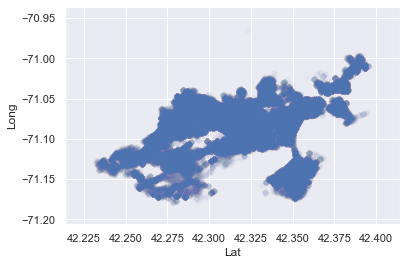

In [13]:
sns.set()
sns.scatterplot(x='Lat',y='Long', data=crime, alpha=0.01)
plt.show()

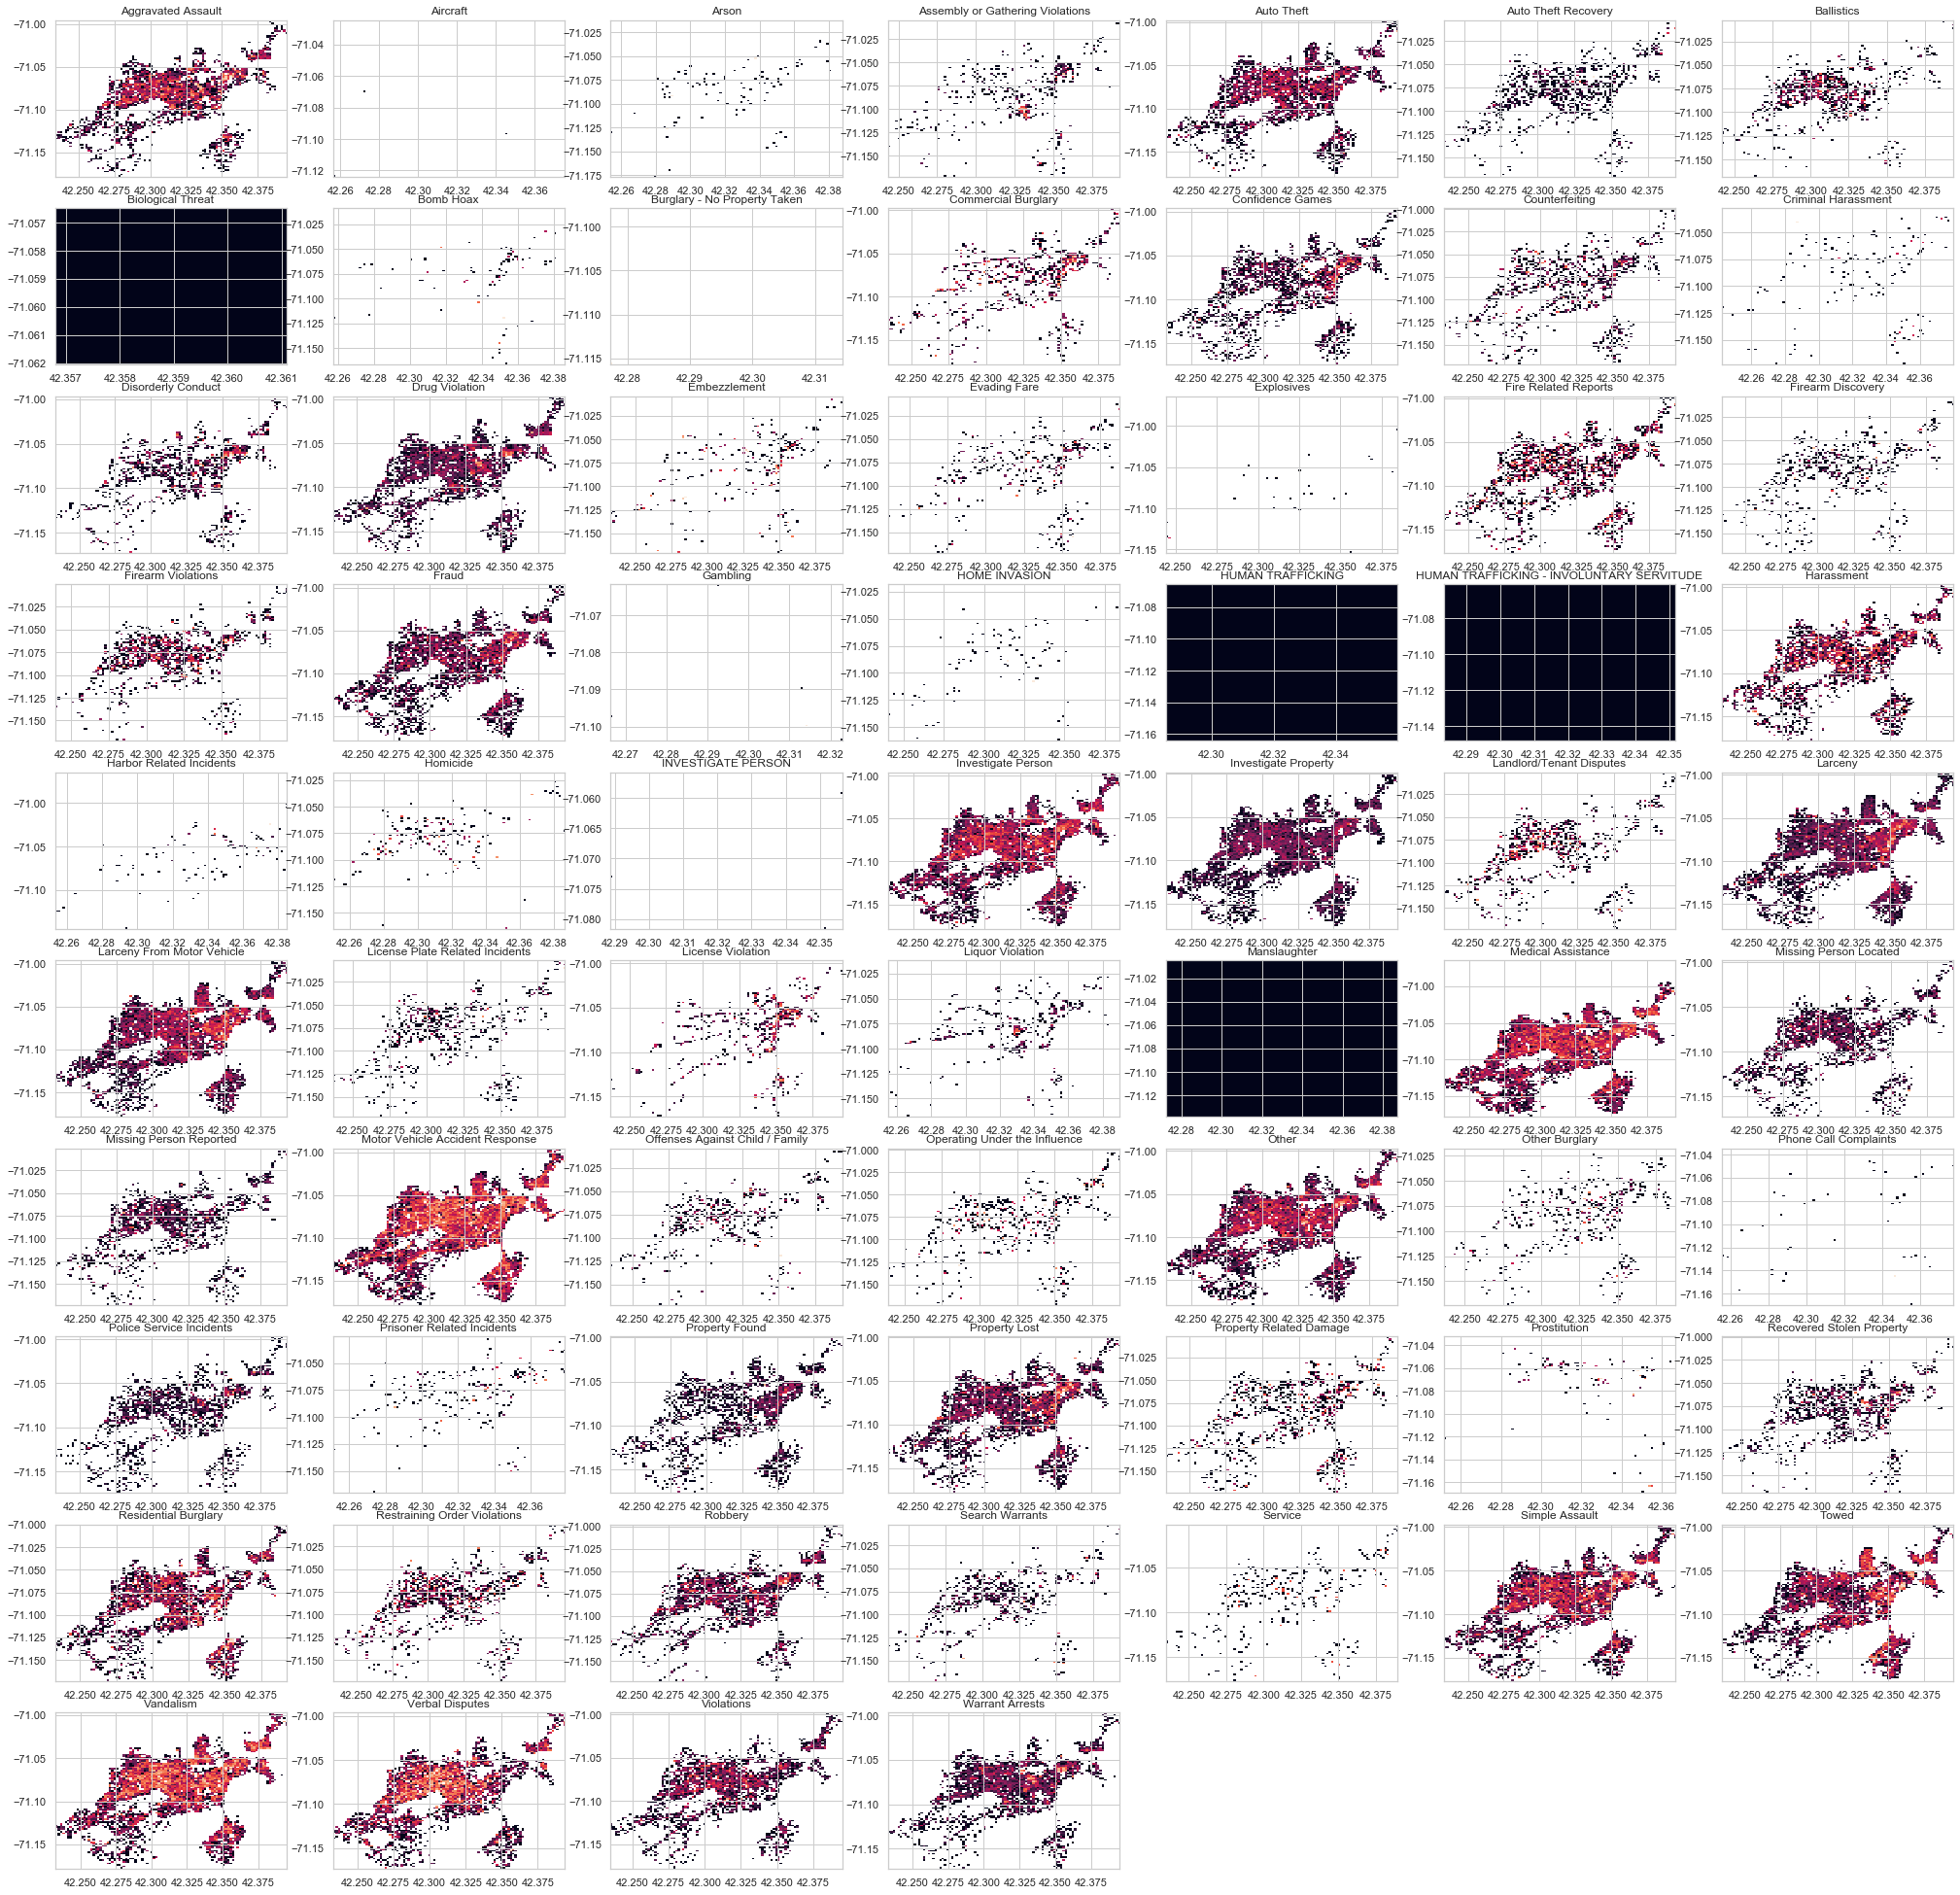

In [14]:
NX=100
NY=100
groups = crime.groupby('OFFENSE_CODE_GROUP')
ii=1
plt.figure(figsize=(35, 35))
sns.set_style('whitegrid')
for name, group in groups:
    plt.subplot(10,7,ii)
    histo, xedges, yedges = np.histogram2d(np.array(group.Lat),np.array(group.Long), bins=(NX,NY))
    myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(histo.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.title(name)
    ii+=1
del groups

## Data Cleaning and Feature Engineering

In [15]:
labels = crime['OFFENSE_CODE_GROUP'].astype('category').cat.categories.tolist()
replace_with_int = {'OFFENSE_CODE_GROUP' : {k: v for k,v in zip(labels,list(range(0,len(labels))))}}

In [16]:
crime['date_day'] = [datetime.strptime(i,"%Y-%m-%d %H:%M:%S").day for i in crime.occured_on_dttm]

In [17]:
def get_season(x):
    if x in [5, 6, 7]:
        r = 'summer'
    elif x in [8, 9, 10]:
        r = 'fall'
    elif x in [11, 12, 1]:
        r = 'winter'
    elif x in [2, 3, 4]:
        r = 'spring'
    return r

In [18]:
crime['season'] = [get_season(i) for i in crime.MONTH]

In [22]:
##Categorizing the season column using Dummy Vars : the reason is because there is no Hierarchy..
#meaning that, "Fall IS NOT Higher or Better than Summer"

def data_prep(df):
    
    df_clean = df.drop(['UCR_PART','OFFENSE_CODE','OFFENSE_DESCRIPTION','STREET','YEAR','Location_lat','Location_long','date_occured','REPORTING_AREA'], axis = 1)
    df_clean.drop(['Unnamed: 0'], axis = 1, inplace = True)
    
    def parse_time(x):
            DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
            mins=DD.minute #*60+DD.minute
            return mins
        
    
    df_clean['mins']=[parse_time(x) for x in df_clean.occured_on_dttm]

    df_clean_onehot = pd.get_dummies(df_clean, columns=['season'], prefix = [''])
    s = (len(list(df_clean_onehot.columns))-len(df_clean.season.value_counts()))
    df_clean = pd.concat([df_clean,df_clean_onehot.iloc[:,s:]], axis=1)

    ##Categorizing the DayOFWeek column using Dummy Vars 
    df_clean_onehot = pd.get_dummies(df_clean, columns=['DAY_OF_WEEK'], prefix = [''])
    l = (len(list(df_clean_onehot.columns))-len(df_clean.DAY_OF_WEEK.value_counts()))
    df_clean = pd.concat([df_clean,df_clean_onehot.iloc[:,l:]],axis=1)

    ##Categorizing the MONTH column using Dummy Vars : the reason is because there is no Hierarchy..
    #meaning that, "FEB IS NOT Higher or Better than JAN"
    #This insight was shown from the EDA result (forecasting data with trend might be a different case)

    df_clean_onehot = pd.get_dummies(df_clean, columns=['MONTH'], prefix = ['month'])
    n = (len(list(df_clean_onehot.columns))-len(df_clean.MONTH.value_counts()))
    df_clean = pd.concat([df_clean,df_clean_onehot.iloc[:,n:]],axis=1)

    ##Categorizing the District column using Dummy Vars 

    df_clean_onehot = pd.get_dummies(df_clean, columns=['DISTRICT'], prefix = [''])
    o = (len(list(df_clean_onehot.columns))-len(df_clean.DISTRICT.value_counts()))
    df_clean = pd.concat([df_clean,df_clean_onehot.iloc[:,o:]],axis=1)

    ##changing the Output Variables to integer
    labels = df_clean['OFFENSE_CODE_GROUP'].astype('category').cat.categories.tolist()
    replace_with_int = {'OFFENSE_CODE_GROUP' : {k: v for k,v in zip(labels,list(range(0,len(labels))))}}
    df_clean.replace(replace_with_int, inplace=True)

    #Normalizing the columns
    def norm_func(i):
        r = (i-min(i))/(max(i)-min(i))
        return(r)

    df_clean['normHOUR']=norm_func(df_clean.HOUR)
    df_clean['normmins']=norm_func(df_clean.mins)
    df_clean['normdate_day']=norm_func(df_clean.date_day)
    df_clean['normLat']=norm_func(df_clean.Lat)
    df_clean['normLong']=norm_func(df_clean.Long)


    ##removing the unused columns
    df_clean.drop(columns = ['season','DAY_OF_WEEK','Lat','Long','HOUR','date_day','MONTH','DISTRICT','occured_on_dttm','INCIDENT_NUMBER'], axis = 1,inplace=True)
    return(df_clean)

In [25]:
crime_clean = data_prep(crime)
crime_clean.head()

,OFFENSE_CODE_GROUP,SHOOTING,mins,_fall,_spring,_summer,_winter,_Friday,_Monday,_Saturday,...,_D14,_D4,_E13,_E18,_E5,normHOUR,normmins,normdate_day,normLat,normLong
0,4,0,28,1,0,0,0,0,0,0,...,0,0,0,1,0,0.391304,0.474576,0.400000,0.166664,0.265635
1,4,0,11,1,0,0,0,0,0,1,...,0,0,0,1,0,0.869565,0.186441,0.366667,0.182495,0.288208
2,4,0,12,1,0,0,0,0,0,1,...,1,0,0,0,0,0.652174,0.203390,0.366667,0.737641,0.202690
3,4,0,41,1,0,0,0,0,0,1,...,0,1,0,0,0,0.173913,0.694915,0.366667,0.719817,0.475690
4,4,0,8,1,0,0,0,0,0,0,...,0,0,0,0,0,0.347826,0.135593,0.033333,0.918859,0.521505


## Splitting the Train & Test Data for Model

In [26]:
split = np.random.rand(len(crime_clean)) < 0.8
train = crime_clean[split]
test = crime_clean[~split]

In [27]:
print('entire dataset :',len(crime_clean.OFFENSE_CODE_GROUP.value_counts().index), 'offense codes')
print('train dataset :',len(crime_clean.OFFENSE_CODE_GROUP.value_counts().index), 'offense codes')
print('test dataset :',len(crime_clean.OFFENSE_CODE_GROUP.value_counts().index), 'offense codes')

entire dataset : 67 offense codes
train dataset : 67 offense codes
test dataset : 67 offense codes


In [29]:
test.to_csv('/Users/jenniferwu/Desktop/MSBA/Fall 2019/Data Analytics/Bostontest_raw.csv',encoding='utf-8', index=False)

## Checking Train Data

In [30]:
train = train.reset_index(drop = True)
train.head()

,OFFENSE_CODE_GROUP,SHOOTING,mins,_fall,_spring,_summer,_winter,_Friday,_Monday,_Saturday,...,_D14,_D4,_E13,_E18,_E5,normHOUR,normmins,normdate_day,normLat,normLong
0,4,0,28,1,0,0,0,0,0,0,...,0,0,0,1,0,0.391304,0.474576,0.400000,0.166664,0.265635
1,4,0,11,1,0,0,0,0,0,1,...,0,0,0,1,0,0.869565,0.186441,0.366667,0.182495,0.288208
2,4,0,12,1,0,0,0,0,0,1,...,1,0,0,0,0,0.652174,0.203390,0.366667,0.737641,0.202690
3,4,0,41,1,0,0,0,0,0,1,...,0,1,0,0,0,0.173913,0.694915,0.366667,0.719817,0.475690
4,4,0,8,1,0,0,0,0,0,0,...,0,0,0,0,0,0.347826,0.135593,0.033333,0.918859,0.521505


## Training the neural network model

In [31]:
##Change df into np.array since Tensorflow works w array

trainnparray = train.values

TrainData   = trainnparray[:, 1:]
TrainLabels = trainnparray[:, [0]]

TrainLabels = TrainLabels.astype('float32')
TrainData = TrainData.astype('float32')

trainnparray.shape

(319851, 43)

In [35]:
model = Sequential()
model.add(Dense(67, input_shape=(42,)))
model.add(Dense(128, activation='relu', input_dim=512))
model.add(Dense(90, activation='relu', input_dim=128))
model.add(Dense(67, activation='softmax', input_dim=90))
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# The fit() method - trains the model
model.fit(TrainData, TrainLabels, nb_epoch=20)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Epoch 1/20
319851/319851 [==============================] - 13s 40us/step - loss: 3.2546 - accuracy: 0.1221
Epoch 2/20
319851/319851 [==============================] - 12s 38us/step - loss: 3.1964 - accuracy: 0.13062s - loss: 3.1971  - ETA - ETA
Epoch 3/20
319851/319851 [==============================] - 13s 41us/step - loss: 3.1808 - accuracy: 0.1330
Epoch 4/20
319851/319851 [==============================] - 14s 44us/step - loss: 3.1738 - accuracy: 0.1347
Epoch 5/20
319851/319851 [==============================] - 14s 43us/step - loss: 3.1690 - accuracy: 0.1353
Epoch 6/20
319851/319851 [==============================] - 14s 44us/step - loss: 3.1655 - accuracy: 0.1356
Epoch 7/20
319851/319851 [==============================] - 13s 40us/step - loss: 3.1633 - accuracy: 0.1368
Epoch 8/20
319851/319851 [==============================] - 13s 39us/step - loss: 3.1607 - accuracy: 0.1373
Epoch 9/20
319851/319851 [==============================] - 12s 39us/step - loss: 3.1587 - accuracy: 0.137

## Checking Test Data

In [36]:
test
test.head()

,OFFENSE_CODE_GROUP,SHOOTING,mins,_fall,_spring,_summer,_winter,_Friday,_Monday,_Saturday,...,_D14,_D4,_E13,_E18,_E5,normHOUR,normmins,normdate_day,normLat,normLong
20,43,0,40,1,0,0,0,0,0,1,...,0,0,0,0,0,0.956522,0.677966,0.900000,0.329903,0.505417
24,43,0,25,1,0,0,0,0,0,0,...,0,0,0,0,0,0.086957,0.423729,0.933333,0.923430,0.675608
34,65,0,45,1,0,0,0,0,0,0,...,0,0,0,0,0,0.043478,0.762712,0.933333,0.578167,0.478613
38,21,0,50,1,0,0,0,0,0,0,...,0,0,0,0,0,0.043478,0.847458,0.933333,0.322284,0.406051
43,0,0,8,1,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,0.135593,0.933333,0.465465,0.530655


In [37]:
##Change df into np.arrat since Tensorflow works w array
testnparray = test.values


TestData   = testnparray[:,1:]
TestLabels = testnparray[:, [0]]

TestLabels = TestLabels.astype('float32')
TestData = TestData.astype('float32')

## Evaluate the model on the cleaned test data

In [38]:
test_loss, test_acc = model.evaluate(TrainData, TrainLabels)  
print('Test Loss:', test_loss,
      'Test Accuracy:',test_acc,
       sep = '\n')

319851/319851 [==============================] - 6s 18us/step
Test Loss:
3.118833844509076
Test Accuracy:
0.14710912108421326


### It is good that test has lower loss or roughly similar to train loss. This indicates that there are no overfitting and that the train data might be more complicated so there is higher loss.

In [42]:
#Now Exporting the predictions
predictions = model.predict(TestData)
predictiondata=pd.DataFrame(data=predictions) 
predictiondata.drop([0], axis =1, inplace = True) #removing the 0th class auto created by TF
predictiondata.rename(columns = {i:j for i,j in zip(predictiondata.columns,labels)}, inplace = True)
predictiondata['MaxProb'] = [np.max(i) for i in predictions]
predictiondata['MaxProbLabel'] = [labels[np.argmax(i)-1] for i in predictions]

In [43]:
predictiondata.to_csv('/Users/jenniferwu/Desktop/MSBA/Fall 2019/Data Analytics/Bostonpredictionoutput.csv'
                      ,encoding='utf-8', index=False)

In [44]:
predictiondata.head()

,Aggravated Assault,Aircraft,Arson,Assembly or Gathering Violations,Auto Theft,Auto Theft Recovery,Ballistics,Biological Threat,Bomb Hoax,Burglary - No Property Taken,...,Robbery,Search Warrants,Service,Simple Assault,Towed,Vandalism,Verbal Disputes,Violations,MaxProb,MaxProbLabel
0,8.035412e-19,0.000015,0.001392,0.009517,0.001625,0.008052,1.144132e-20,3.260982e-10,2.118689e-18,0.000747,...,0.000132,0.000174,0.080037,0.023727,0.057207,0.147677,0.015140,0.008283,0.147942,Missing Person Reported
1,3.031325e-04,0.000324,0.004013,0.007896,0.001337,0.002662,1.346450e-12,3.777043e-05,1.542481e-10,0.003953,...,0.001082,0.000339,0.086941,0.044665,0.060990,0.040877,0.015790,0.012374,0.147242,Missing Person Reported
2,9.661306e-11,0.000148,0.047846,0.007851,0.002424,0.006204,4.055751e-12,6.773647e-11,4.745268e-14,0.003319,...,0.000349,0.000135,0.083651,0.014058,0.043255,0.049397,0.019783,0.023612,0.109769,Manslaughter
3,6.974628e-11,0.000131,0.007314,0.009221,0.002519,0.014842,2.228173e-13,5.343669e-14,4.105717e-13,0.003717,...,0.000758,0.000055,0.055316,0.029262,0.043241,0.088142,0.031695,0.017768,0.166701,Missing Person Reported
4,1.122424e-16,0.000028,0.000537,0.013111,0.001387,0.005548,2.251964e-16,6.564111e-09,2.498010e-15,0.001925,...,0.000781,0.000103,0.075878,0.026314,0.059316,0.089894,0.016986,0.016768,0.143245,Missing Person Reported
